[Link to Github Repository](https://github.com/RoryAJames/CIND-820/tree/3253a4fe43331c026f5bbf49636ffb9ea60b0e50)

In [1]:
#Import packages

import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')

## Working With Building Permits Data

In [2]:
url = 'https://opendata.vancouver.ca/api/v2/catalog/datasets/issued-building-permits/exports/geojson?limit=-1&offset=0&timezone=UTC'
data = requests.get(url)
permits_df = gpd.GeoDataFrame().from_features(data.json())
permits_df = permits_df.set_crs('EPSG:4326').to_crs('EPSG:3857') # Set all geopandas dataframes to the same coordinate reference system

In [3]:
permits_df.head()

,geometry,permitnumber,permitnumbercreateddate,issuedate,permitelapseddays,projectvalue,typeofwork,address,projectdescription,permitcategory,...,applicantaddress,propertyuse,specificusecategory,buildingcontractor,buildingcontractoraddress,issueyear,geolocalarea,yearmonth,geo_point_2d,geom
0,POINT (-13697650.143 6318425.983),BP-2019-05613,2019-12-12,2020-07-20,221,15000.0,Demolition / Deconstruction,"2760 E 15TH AVENUE, Vancouver, BC V5M 2K3",Low Density Housing - Demolition / Deconstruct...,None,...,"2219 E 50th Ave\r\nVANCOUVER, BC V5P 1V6",[Dwelling Uses],[Single Detached House w/Sec Suite],All Right Trucking 99 Ltd,None,2020,Renfrew-Collingwood,2020-07,"{'lon': -123.0480848, 'lat': 49.2560855}",NaN
1,POINT (-13706521.672 6310787.388),BP-2018-01377,2018-03-14,2018-05-30,77,0.0,Salvage and Abatement,"8221 FREMLIN STREET, Vancouver, BC V6P 3W9",Low Density Housing - Salvage and Abatement - ...,None,...,"2219 E 50th Ave\r\nVANCOUVER, BC V5P 1V6",[Dwelling Uses],[Single Detached House w/Sec Suite],All Right Trucking 99 Ltd,None,2018,Marpole,2018-05,"{'lon': -123.1277791, 'lat': 49.2112792}",NaN
2,POINT (-13699859.356 6313875.062),DB-2017-00278,2017-01-17,2017-10-11,267,15000.0,Demolition / Deconstruction,"6042 COMMERCIAL STREET, Vancouver, BC V5P 3N9",Low Density Housing - Demolition / Deconstruct...,None,...,"108 East 51 Ave Vancouver BC\r\nvancouver, BC ...",[Dwelling Uses],[Single Detached House w/Sec Suite],All Right Trucking 99 Ltd,None,2017,Victoria-Fraserview,2017-10,"{'lon': -123.0679305, 'lat': 49.2293957}",NaN
3,POINT (-13698928.269 6312850.456),BP-2016-04133,2016-12-02,2017-06-13,193,15000.0,Demolition / Deconstruction,"6663 NANAIMO STREET, Vancouver, BC V5P 4L3",Low Density Housing - Demolition / Deconstruct...,None,...,"6585 Brooks Street\r\nVancouver, BC V5S 3J6",[Dwelling Uses],[Single Detached House w/Sec Suite],All Right Trucking 99 Ltd,None,2017,Victoria-Fraserview,2017-06,"{'lon': -123.0595664, 'lat': 49.2233847}",NaN
4,POINT (-13698928.269 6312850.456),BP-2016-04134,2016-12-02,2017-03-14,102,0.0,Salvage and Abatement,"6663 NANAIMO STREET, Vancouver, BC V5P 4L3",Low Density Housing - Salvage and Abatement - ...,None,...,"6585 Brooks Street\r\nVancouver, BC V5S 3J6",[Dwelling Uses],[Single Detached House w/Sec Suite],All Right Trucking 99 Ltd,None,2017,Victoria-Fraserview,2017-03,"{'lon': -123.0595664, 'lat': 49.2233847}",NaN


### Data Cleaning & Preparation

In [4]:
#Check data types

permits_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34173 entries, 0 to 34172
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   geometry                   33823 non-null  geometry
 1   permitnumber               34173 non-null  object  
 2   permitnumbercreateddate    34173 non-null  object  
 3   issuedate                  34173 non-null  object  
 4   permitelapseddays          34173 non-null  int64   
 5   projectvalue               34173 non-null  float64 
 6   typeofwork                 34173 non-null  object  
 7   address                    34102 non-null  object  
 8   projectdescription         34173 non-null  object  
 9   permitcategory             19506 non-null  object  
 10  applicant                  34173 non-null  object  
 11  applicantaddress           34086 non-null  object  
 12  propertyuse                34168 non-null  object  
 13  specificusecategory    

In [5]:
#Remove unnecessary columns

cols_to_keep = ['geometry','projectvalue','typeofwork','propertyuse','issueyear','geolocalarea']

permits_df = permits_df[cols_to_keep]

permits_df.head()

,geometry,projectvalue,typeofwork,propertyuse,issueyear,geolocalarea
0,POINT (-13697650.143 6318425.983),15000.0,Demolition / Deconstruction,[Dwelling Uses],2020,Renfrew-Collingwood
1,POINT (-13706521.672 6310787.388),0.0,Salvage and Abatement,[Dwelling Uses],2018,Marpole
2,POINT (-13699859.356 6313875.062),15000.0,Demolition / Deconstruction,[Dwelling Uses],2017,Victoria-Fraserview
3,POINT (-13698928.269 6312850.456),15000.0,Demolition / Deconstruction,[Dwelling Uses],2017,Victoria-Fraserview
4,POINT (-13698928.269 6312850.456),0.0,Salvage and Abatement,[Dwelling Uses],2017,Victoria-Fraserview


In [6]:
#Rename columns to more appropriate names

new_columns = {'projectvalue':'ProjectValue',
               'typeofwork':'WorkType',
               'propertyuse':'PropertyUse',
               'issueyear':'Year',
               'geolocalarea':'Area'
               }

permits_df.rename(columns=new_columns, inplace=True)

In [7]:
permits_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34173 entries, 0 to 34172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geometry      33823 non-null  geometry
 1   ProjectValue  34173 non-null  float64 
 2   WorkType      34173 non-null  object  
 3   PropertyUse   34168 non-null  object  
 4   Year          34173 non-null  object  
 5   Area          33816 non-null  object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 1.6+ MB


In [8]:
#Convert year column to integer

permits_df['Year'] = permits_df['Year'].astype(str).astype(int)
permits_df.dtypes

geometry        geometry
ProjectValue     float64
WorkType          object
PropertyUse       object
Year               int32
Area              object
dtype: object

In [9]:
permits_df.head()

,geometry,ProjectValue,WorkType,PropertyUse,Year,Area
0,POINT (-13697650.143 6318425.983),15000.0,Demolition / Deconstruction,[Dwelling Uses],2020,Renfrew-Collingwood
1,POINT (-13706521.672 6310787.388),0.0,Salvage and Abatement,[Dwelling Uses],2018,Marpole
2,POINT (-13699859.356 6313875.062),15000.0,Demolition / Deconstruction,[Dwelling Uses],2017,Victoria-Fraserview
3,POINT (-13698928.269 6312850.456),15000.0,Demolition / Deconstruction,[Dwelling Uses],2017,Victoria-Fraserview
4,POINT (-13698928.269 6312850.456),0.0,Salvage and Abatement,[Dwelling Uses],2017,Victoria-Fraserview


#### Data Cleaning & Preparation - Property Use

In [10]:
#Check value counts for property use

permits_df.PropertyUse.value_counts()

[Dwelling Uses]                                                   24019
[Office Uses]                                                      4237
[Retail Uses]                                                      1696
[Service Uses]                                                     1339
[Institutional Uses]                                                670
                                                                  ...  
[Cultural/Recreational Uses, Parking Uses, Service Uses]              1
[Live-Work Uses, Office Uses, Retail Uses]                            1
[Dwelling Uses, Institutional Uses, Office Uses, Retail Uses]         1
[Manufacturing Uses, Office Uses, Retail Uses, Service Uses]          1
[Dwelling Uses, Manufacturing Uses, Office Uses, Parking Uses]        1
Name: PropertyUse, Length: 130, dtype: int64

In [11]:
# Create a number of uses column by counting the number of items in the property use column which is a list of values

permits_df["NumberOfUses"] = permits_df.PropertyUse.str.len()

#Remove the rows where the number of uses is blank

permits_df = permits_df[permits_df['NumberOfUses'].notna()]

#Convert number of uses to an integer

permits_df["NumberOfUses"] = permits_df["NumberOfUses"].astype(int)

In [12]:
permits_df.NumberOfUses.value_counts()

1    33168
2      739
3      187
4       58
5       16
Name: NumberOfUses, dtype: int64

In [13]:
#Create a new revised property use column that converts the original column from a list of values into a string of values

permits_df['PropertyUseRevised'] = permits_df.PropertyUse.apply(lambda x: ', '.join([str(i) for i in x]))

permits_df.head()

,geometry,ProjectValue,WorkType,PropertyUse,Year,Area,NumberOfUses,PropertyUseRevised
0,POINT (-13697650.143 6318425.983),15000.0,Demolition / Deconstruction,[Dwelling Uses],2020,Renfrew-Collingwood,1,Dwelling Uses
1,POINT (-13706521.672 6310787.388),0.0,Salvage and Abatement,[Dwelling Uses],2018,Marpole,1,Dwelling Uses
2,POINT (-13699859.356 6313875.062),15000.0,Demolition / Deconstruction,[Dwelling Uses],2017,Victoria-Fraserview,1,Dwelling Uses
3,POINT (-13698928.269 6312850.456),15000.0,Demolition / Deconstruction,[Dwelling Uses],2017,Victoria-Fraserview,1,Dwelling Uses
4,POINT (-13698928.269 6312850.456),0.0,Salvage and Abatement,[Dwelling Uses],2017,Victoria-Fraserview,1,Dwelling Uses


In [14]:
#Change property use revised column base on the number of uses column. If the number of uses is greater than 1, change the value of property use revised to mixed use, otherwise keep it the same.

permits_df['PropertyUseRevised'] = np.where(permits_df.NumberOfUses > 1, 'Mixed Uses', permits_df.PropertyUseRevised)

In [15]:
permits_df.PropertyUseRevised.value_counts()

Dwelling Uses                      24019
Office Uses                         4237
Retail Uses                         1696
Service Uses                        1339
Mixed Uses                          1000
Institutional Uses                   670
Cultural/Recreational Uses           544
Manufacturing Uses                   250
Wholesale Uses                       127
Transportation and Storage Uses      113
Parking Uses                          93
Utility and Communication Uses        56
Live-Work Uses                        19
Agricultural Uses                      3
Mural                                  1
Deposition or Extraction Uses          1
Name: PropertyUseRevised, dtype: int64

In [16]:
#Remove number of uses and original property use columns now that they are redundant

permits_df = permits_df[['geometry','ProjectValue','WorkType','Year','Area','PropertyUseRevised']]

permits_df.head()

,geometry,ProjectValue,WorkType,Year,Area,PropertyUseRevised
0,POINT (-13697650.143 6318425.983),15000.0,Demolition / Deconstruction,2020,Renfrew-Collingwood,Dwelling Uses
1,POINT (-13706521.672 6310787.388),0.0,Salvage and Abatement,2018,Marpole,Dwelling Uses
2,POINT (-13699859.356 6313875.062),15000.0,Demolition / Deconstruction,2017,Victoria-Fraserview,Dwelling Uses
3,POINT (-13698928.269 6312850.456),15000.0,Demolition / Deconstruction,2017,Victoria-Fraserview,Dwelling Uses
4,POINT (-13698928.269 6312850.456),0.0,Salvage and Abatement,2017,Victoria-Fraserview,Dwelling Uses


#### Data Cleaning & Preparation - Work Type

In [17]:
permits_df.WorkType.value_counts()

Addition / Alteration                   16564
New Building                             7813
Salvage and Abatement                    4910
Demolition / Deconstruction              4515
Temporary Building / Structure            321
Outdoor Uses (No Buildings Proposed)       45
Name: WorkType, dtype: int64

In [18]:
#Rename some of the values in the work type field

permits_df['WorkType'] = permits_df['WorkType'].replace({'Addition / Alteration':'Addition',
                                                         'Salvage and Abatement':'Salvage',
                                                         'Demolition / Deconstruction':'Demolition',
                                                         'Temporary Building / Structure':'Temporary Building',
                                                         'Outdoor Uses (No Buildings Proposed)':'Outdoor Use'
                                                         })

permits_df.WorkType.value_counts()

Addition              16564
New Building           7813
Salvage                4910
Demolition             4515
Temporary Building      321
Outdoor Use              45
Name: WorkType, dtype: int64

#### Data Cleaning & Preparation - Year

In [19]:
permits_df.Year.value_counts()

2018    6758
2017    6729
2022    5667
2019    5572
2021    5052
2020    4390
Name: Year, dtype: int64

In [20]:
#Filter the data down to permits that were submitted between the years 2017 and 2019.

permits_df = permits_df[permits_df['Year'].between(2017, 2019)]
permits_df.Year.value_counts()

2018    6758
2017    6729
2019    5572
Name: Year, dtype: int64

### Check For Missing Values

In [21]:
#Check the number of null values in each column

total_missing = permits_df.isnull().sum().sort_values(ascending=False)
percent = (permits_df.isnull().sum()/permits_df.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total_missing, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data.head()

,Total Missing,Percent
Area,151,0.792277
geometry,147,0.771289
ProjectValue,0,0.000000
WorkType,0,0.000000
Year,0,0.000000


In [22]:
#Since there is such a small amount of missing data, drop the rows where there are missing values

permits_df = permits_df.dropna()
permits_df.isnull().sum()

geometry              0
ProjectValue          0
WorkType              0
Year                  0
Area                  0
PropertyUseRevised    0
dtype: int64

# Working With Other Geospatial Datasets

In [23]:
# A function that drops all of the columns in a geopandas dataframe except for the geometry column. This is used on the datasets where you want to return a boolean value.

def geo_column_only(url, col_name):
    r = requests.get(url)
    gdf = gpd.GeoDataFrame().from_features(r.json())
    gdf = gdf.set_crs('EPSG:4326').to_crs('EPSG:3857') #Sets the CRS to the same as the permits data set
    final_table_columns = ['geometry']
    geo_df_with_cols_removed = gdf.drop(columns=[col for col in gdf if col not in final_table_columns]) #Drop a column if its not geometry
    geo_df_with_cols_removed[col_name] = 1 #Assign a value of 1 to the newly created column
    return geo_df_with_cols_removed

#Function to perform a left spatial join on two geopanadas dataframes and drop the right_index column after the join has been performed

def join_reducer(left, right):
    sjoin = gpd.sjoin(left, right, how='left')
    sjoin.drop('index_right', axis=1, inplace=True)
    return sjoin

### Business Improvement Areas

In [24]:
bia_df = geo_column_only('https://opendata.vancouver.ca/api/v2/catalog/datasets/business-improvement-areas-bia/exports/geojson?limit=-1&offset=0&timezone=UTC', 'BusinessImprovementArea')
bia_df.head()

,geometry,BusinessImprovementArea
0,"POLYGON ((-13700143.889 6321936.969, -13700128...",1
1,"MULTIPOLYGON (((-13695742.940 6322624.315, -13...",1
2,"POLYGON ((-13709782.421 6314843.080, -13709781...",1
3,"POLYGON ((-13707842.306 6311277.467, -13707919...",1
4,"POLYGON ((-13707708.568 6320234.155, -13707788...",1


In [25]:
#Spatial join BIA data to the permits data. If a permit is located within a BIA it will be labeled as 1, otherwise it will be labeled as 0.

permits_df = join_reducer(permits_df,bia_df)
permits_df['BusinessImprovementArea'].fillna(0, inplace = True) #Where a permit is not located in a BIA assign it a value of zero
permits_df.head()

,geometry,ProjectValue,WorkType,Year,Area,PropertyUseRevised,BusinessImprovementArea
1,POINT (-13706521.672 6310787.388),0.0,Salvage,2018,Marpole,Dwelling Uses,0.0
2,POINT (-13699859.356 6313875.062),15000.0,Demolition,2017,Victoria-Fraserview,Dwelling Uses,0.0
3,POINT (-13698928.269 6312850.456),15000.0,Demolition,2017,Victoria-Fraserview,Dwelling Uses,0.0
4,POINT (-13698928.269 6312850.456),0.0,Salvage,2017,Victoria-Fraserview,Dwelling Uses,0.0
5,POINT (-13702091.323 6319154.791),15000.0,Demolition,2017,Mount Pleasant,Dwelling Uses,0.0


In [26]:
permits_df.BusinessImprovementArea.value_counts()

0.0    14762
1.0     4146
Name: BusinessImprovementArea, dtype: int64

### Flood Plain Areas

In [27]:
fp_df = geo_column_only('https://opendata.vancouver.ca/api/v2/catalog/datasets/designated-floodplain/exports/geojson?limit=-1&offset=0&timezone=UTC','FloodPlain')
fp_df.head()

,geometry,FloodPlain
0,"POLYGON ((-13695468.072 6319454.037, -13695467...",1
1,"POLYGON ((-13696427.537 6318776.760, -13696642...",1
2,"POLYGON ((-13695858.168 6319254.615, -13695858...",1
3,"POLYGON ((-13695468.072 6319454.037, -13695468...",1
4,"MULTIPOLYGON (((-13711762.162 6321091.018, -13...",1


In [28]:
permits_df = join_reducer(permits_df,fp_df)
permits_df['FloodPlain'].fillna(0, inplace = True) #Where a permit is not located in a flood plain assign it a value of zero
permits_df.head()

,geometry,ProjectValue,WorkType,Year,Area,PropertyUseRevised,BusinessImprovementArea,FloodPlain
1,POINT (-13706521.672 6310787.388),0.0,Salvage,2018,Marpole,Dwelling Uses,0.0,0.0
2,POINT (-13699859.356 6313875.062),15000.0,Demolition,2017,Victoria-Fraserview,Dwelling Uses,0.0,0.0
3,POINT (-13698928.269 6312850.456),15000.0,Demolition,2017,Victoria-Fraserview,Dwelling Uses,0.0,0.0
4,POINT (-13698928.269 6312850.456),0.0,Salvage,2017,Victoria-Fraserview,Dwelling Uses,0.0,0.0
5,POINT (-13702091.323 6319154.791),15000.0,Demolition,2017,Mount Pleasant,Dwelling Uses,0.0,0.0


In [29]:
permits_df.FloodPlain.value_counts()

0.0    18457
1.0      451
Name: FloodPlain, dtype: int64

### Transit Stations

In [30]:
transit_url = 'https://opendata.vancouver.ca/api/v2/catalog/datasets/rapid-transit-stations/exports/geojson?limit=-1&offset=0&timezone=UTC'
transit_data = requests.get(transit_url)
transit_df = gpd.GeoDataFrame().from_features(transit_data.json())
transit_df = transit_df.set_crs('EPSG:4326').to_crs('EPSG:3857')
transit_df.head()

,geometry,station,geo_local_area
0,POINT (-13705329.627 6310492.370),MARINE DRIVE,Marpole
1,POINT (-13701087.405 6320080.163),VCC - CLARK,Strathcona
2,POINT (-13698516.956 6317093.472),NANAIMO,Renfrew-Collingwood
3,POINT (-13703496.877 6321341.731),MAIN ST. - SCIENCE WORLD,Downtown
4,POINT (-13704494.065 6322410.505),STADIUM - CHINATOWN,Downtown


In [31]:
#Perform a nearest spatial join to calculate the distance between each permit and the nearest transit station in meters
permits_df = permits_df.sjoin_nearest(transit_df, how = 'left', distance_col='DistanceToNearestTransitStation')

#Remove unnecessary columns after calculating distance to nearest transit station via spatial join
cols_to_keep_final = ['geometry','ProjectValue','WorkType','Area','PropertyUseRevised','BusinessImprovementArea','FloodPlain','DistanceToNearestTransitStation']
permits_df = permits_df[cols_to_keep_final]

permits_df.head()

,geometry,ProjectValue,WorkType,Area,PropertyUseRevised,BusinessImprovementArea,FloodPlain,DistanceToNearestTransitStation
1,POINT (-13706521.672 6310787.388),0.0,Salvage,Marpole,Dwelling Uses,0.0,0.0,1228.009557
2,POINT (-13699859.356 6313875.062),15000.0,Demolition,Victoria-Fraserview,Dwelling Uses,0.0,0.0,3487.147788
3,POINT (-13698928.269 6312850.456),15000.0,Demolition,Victoria-Fraserview,Dwelling Uses,0.0,0.0,3865.866478
4,POINT (-13698928.269 6312850.456),0.0,Salvage,Victoria-Fraserview,Dwelling Uses,0.0,0.0,3865.866478
5,POINT (-13702091.323 6319154.791),15000.0,Demolition,Mount Pleasant,Dwelling Uses,0.0,0.0,1365.344275


## Exploratory Data Analysis

### Analyzing Categorical Features

In [32]:
def analyze_cat_cols():

    cat_cols = ['WorkType','Area','PropertyUseRevised','BusinessImprovementArea','FloodPlain']

    for col in cat_cols:
        print('------')
        print(permits_df[col].value_counts())
        
analyze_cat_cols()

------
Addition              9424
New Building          4346
Salvage               2562
Demolition            2366
Temporary Building     184
Outdoor Use             26
Name: WorkType, dtype: int64
------
Downtown                    3030
Kensington-Cedar Cottage    1380
Renfrew-Collingwood         1224
Sunset                      1110
Hastings-Sunrise            1107
Kitsilano                    937
Fairview                     920
Dunbar-Southlands            894
West End                     884
Victoria-Fraserview          867
Riley Park                   861
Mount Pleasant               773
Marpole                      691
Killarney                    641
Grandview-Woodland           591
West Point Grey              555
Kerrisdale                   507
Arbutus-Ridge                475
Oakridge                     426
Shaughnessy                  377
Strathcona                   373
South Cambie                 285
Name: Area, dtype: int64
------
Dwelling Uses                      12

Remove salvage, temporary building and outdoor uses from work type. Salvage should be removed as it is not clear what type of work this permit represents. Outdoor use should be removed due to low frequencies and temporary building should be removed because it does not reflect a structure that is permanent.

In [33]:
wt_to_remove = ['Salvage','Temporary Building','Outdoor Use'] #list of values to remove

permits_df = permits_df[~permits_df.WorkType.isin(wt_to_remove)] #Keep values that are not in the removal list

permits_df.WorkType.value_counts()

Addition        9424
New Building    4346
Demolition      2366
Name: WorkType, dtype: int64

A lot of the revised property uses are low frequency. For this purpose, I will only keep the permits that have value counts greater than 100 as to avoid the curse of dimensionality.

In [34]:
pu_to_remove = ['Wholesale Uses','Transportation and Storage Uses','Parking Uses','Utility and Communication Uses','Live-Work Uses',
                'Deposition or Extraction Uses','Agricultural Uses']

permits_df = permits_df[~permits_df.PropertyUseRevised.isin(pu_to_remove)] #Keep values that are not in the removal list

permits_df.PropertyUseRevised.value_counts()

Dwelling Uses                 10539
Office Uses                    2639
Retail Uses                     940
Service Uses                    736
Mixed Uses                      461
Institutional Uses              338
Cultural/Recreational Uses      171
Manufacturing Uses              125
Name: PropertyUseRevised, dtype: int64

In [35]:
analyze_cat_cols()

------
Addition        9269
New Building    4330
Demolition      2350
Name: WorkType, dtype: int64
------
Downtown                    2894
Kensington-Cedar Cottage    1114
Renfrew-Collingwood          957
Sunset                       885
Fairview                     882
Hastings-Sunrise             872
West End                     852
Kitsilano                    829
Victoria-Fraserview          701
Riley Park                   683
Mount Pleasant               667
Dunbar-Southlands            660
Killarney                    550
Marpole                      539
Grandview-Woodland           494
West Point Grey              427
Kerrisdale                   394
Arbutus-Ridge                373
Oakridge                     345
Strathcona                   325
Shaughnessy                  283
South Cambie                 223
Name: Area, dtype: int64
------
Dwelling Uses                 10539
Office Uses                    2639
Retail Uses                     940
Service Uses                

### Analyzing Project Value - The Dependant Variable

In [36]:
#A function for assessing the distribution of a value and checking if it matches the assumption of normality

def check_distribution(df, col):
    
    #Distribution plot with normal curve
    fig = plt.subplots(figsize=[18,10])
    sns.distplot(df[col], fit=norm)
    
    #Probability plot
    fig = plt.figure(figsize=[18,10])
    res = stats.probplot(df[col], plot=plt)
    
    #Box plot
    fig = plt.figure(figsize=[18,10])
    sns.boxplot(y= col, data=df)
    
    #Shapiro Wilk test for normality
    shapiro_test = stats.shapiro(df[col])

    if shapiro_test.pvalue <= 0.05:
        print("Null hypothesis of normality is rejected.")
    else:
        print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


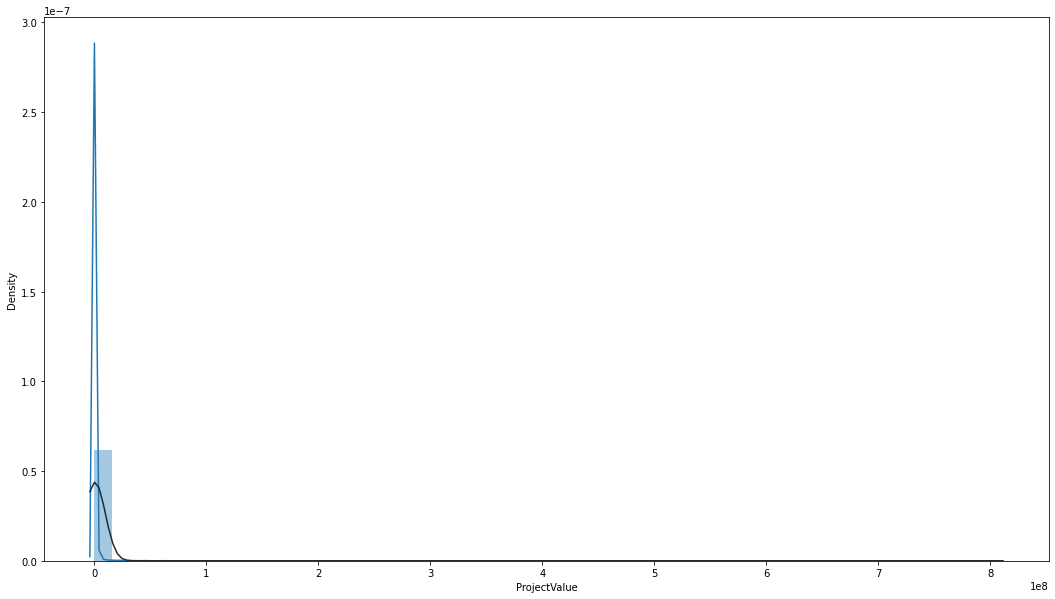

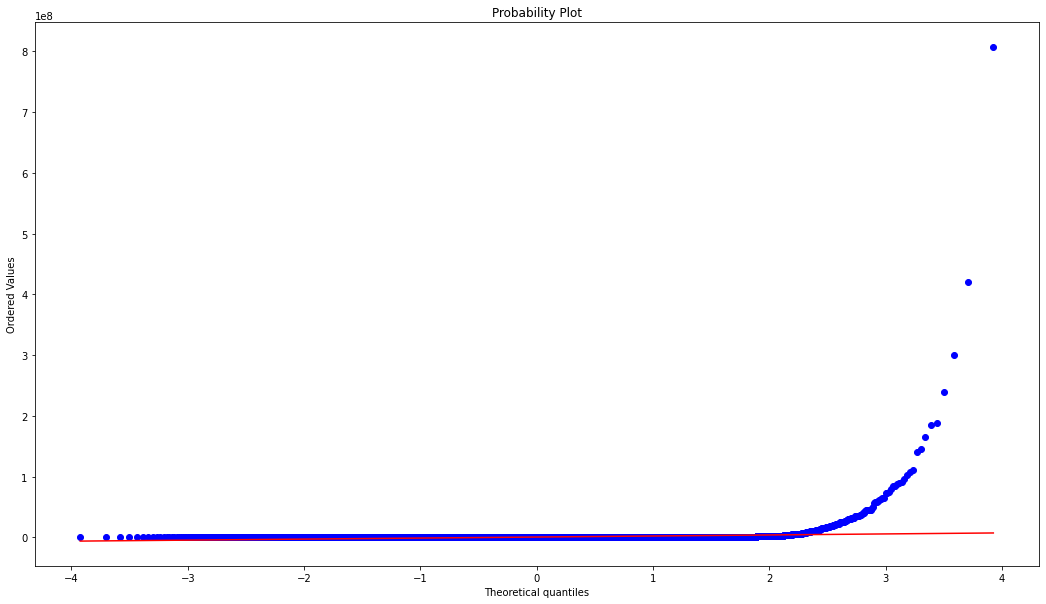

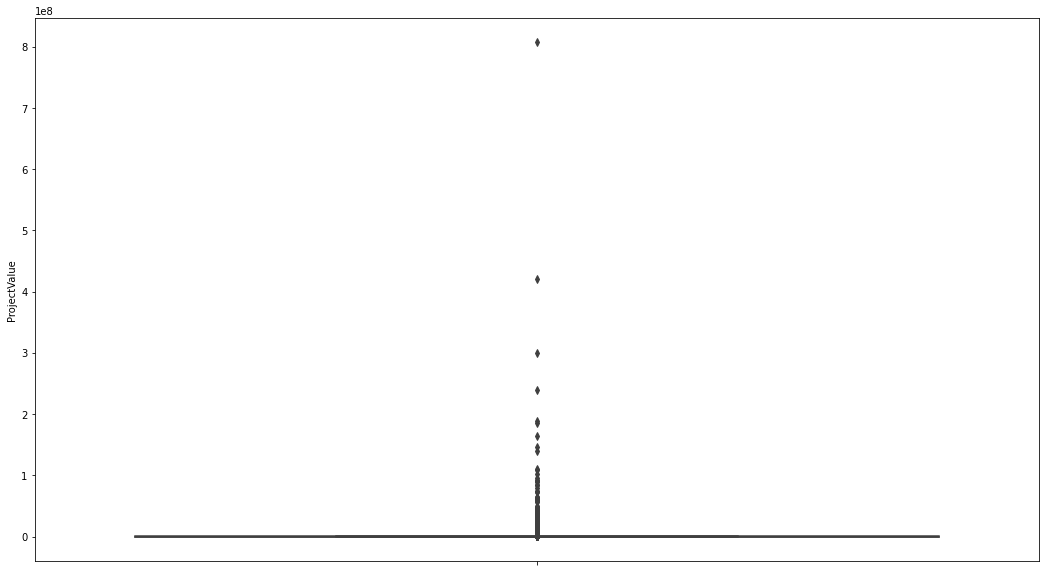

In [37]:
check_distribution(permits_df,'ProjectValue')

There are a large number of permits that have a value of zero. These will be considered errors, and thus removed from the analysis.

In [38]:
#Count how many zero values there are in project value

permits_df[permits_df.ProjectValue == 0].shape[0]

482

In [39]:
#Remove permits with 0 project value

permits_df = permits_df[permits_df.ProjectValue != 0]
permits_df[permits_df.ProjectValue == 0].shape[0]

0

Null hypothesis of normality is rejected.


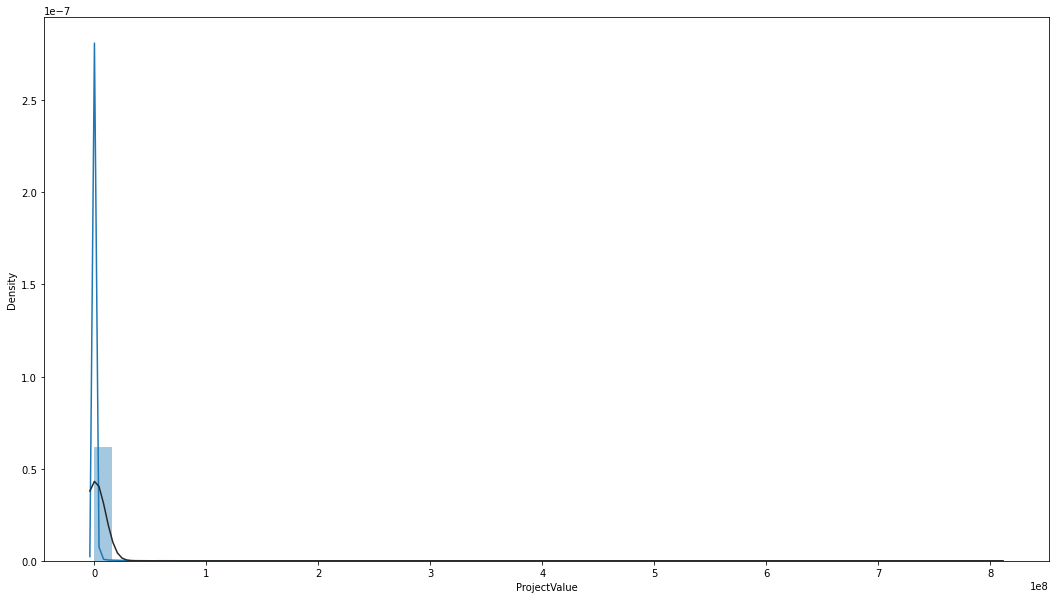

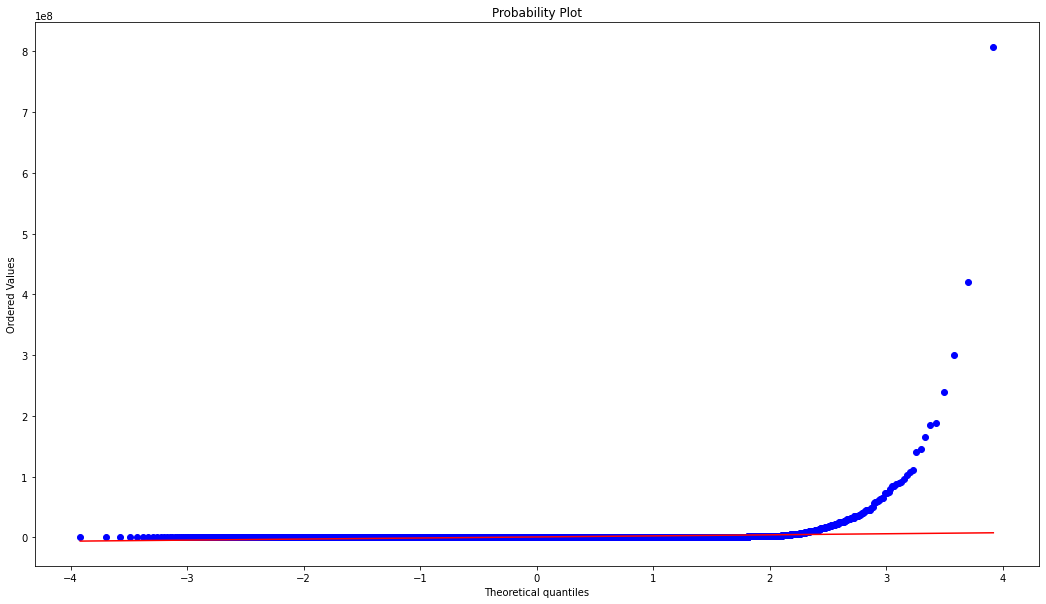

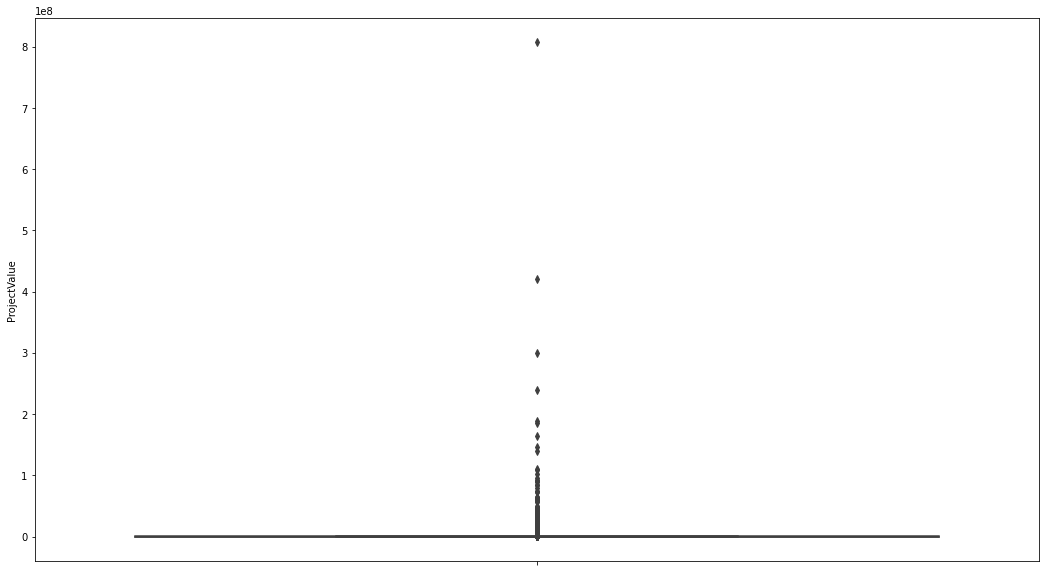

In [40]:
#Recheck the distribution after removing the permits with zero project value
check_distribution(permits_df,'ProjectValue')

In [41]:
permits_df.ProjectValue.min()

1.0

In [42]:
print(f"The 10th percentile value is {permits_df.ProjectValue.quantile(0.10)}")
print(f"The 15th percentile value is {permits_df.ProjectValue.quantile(0.15)}")
print(f"The 20th percentile value is {permits_df.ProjectValue.quantile(0.20)}")
print(f"The 25th percentile value is {permits_df.ProjectValue.quantile(0.25)}")
print(f"The 50th percentile value is {permits_df.ProjectValue.quantile(0.5)}")
print(f"The 75th percentile value is {permits_df.ProjectValue.quantile(0.75)}")
print(f"The 80th percentile value is {permits_df.ProjectValue.quantile(0.80)}")
print(f"The 80th percentile value is {permits_df.ProjectValue.quantile(0.85)}")
print(f"The 90th percentile value is {permits_df.ProjectValue.quantile(0.90)}")
print(f"The 95th percentile value is {permits_df.ProjectValue.quantile(0.95)}")
print(f"The 99th percentile value is {permits_df.ProjectValue.quantile(0.99)}")

The 10th percentile value is 10000.0
The 15th percentile value is 15000.0
The 20th percentile value is 15000.0
The 25th percentile value is 15000.0
The 50th percentile value is 85000.0
The 75th percentile value is 262115.0
The 80th percentile value is 493940.0000000047
The 80th percentile value is 697432.5
The 90th percentile value is 843249.9999999995
The 95th percentile value is 1169849.9999999995
The 99th percentile value is 9006800.000000004


From a practical and logical perspective, it makes sense to remove values greater than the 25th percentile. The dataset is heavily right skewed, with many data points showing a low permit value. Practically, it doesn't seem correct to have permits valued this low as it does not fit with the overall goal of the project.

In [43]:
permits_df = permits_df[(permits_df.ProjectValue > permits_df.ProjectValue.quantile(0.25))]

Null hypothesis of normality is rejected.


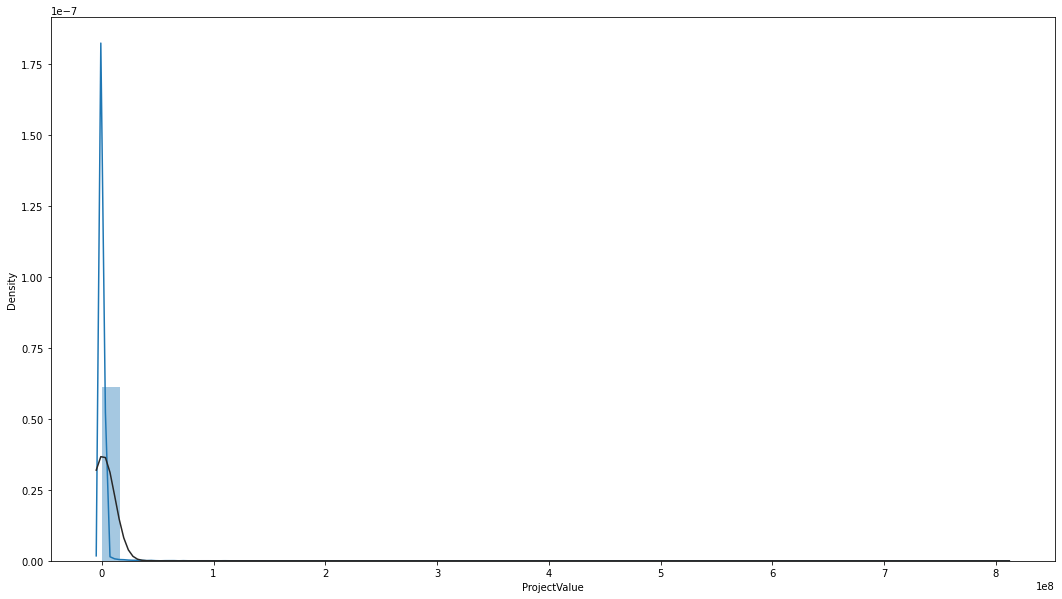

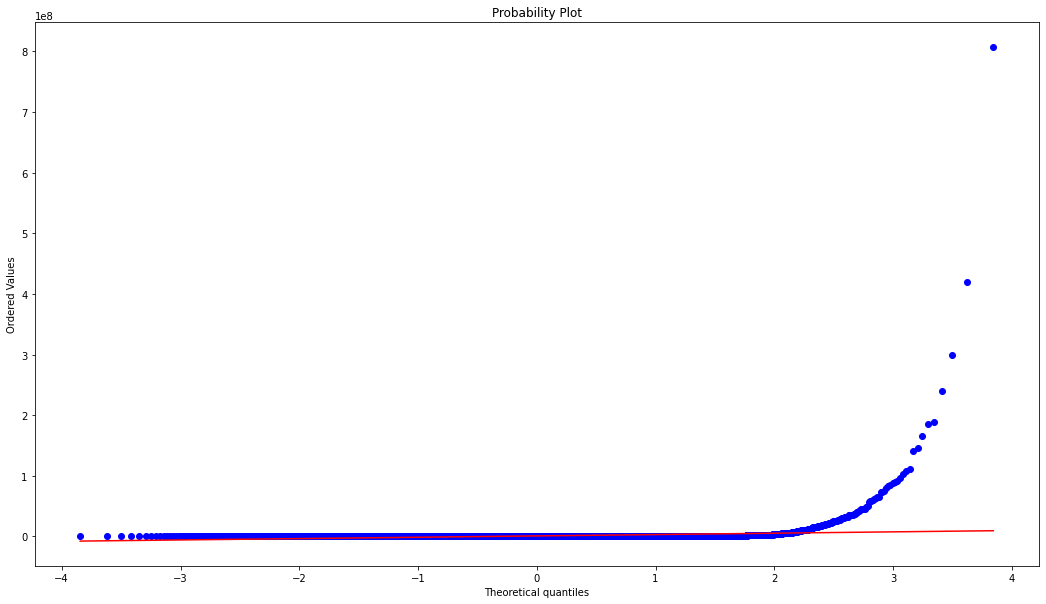

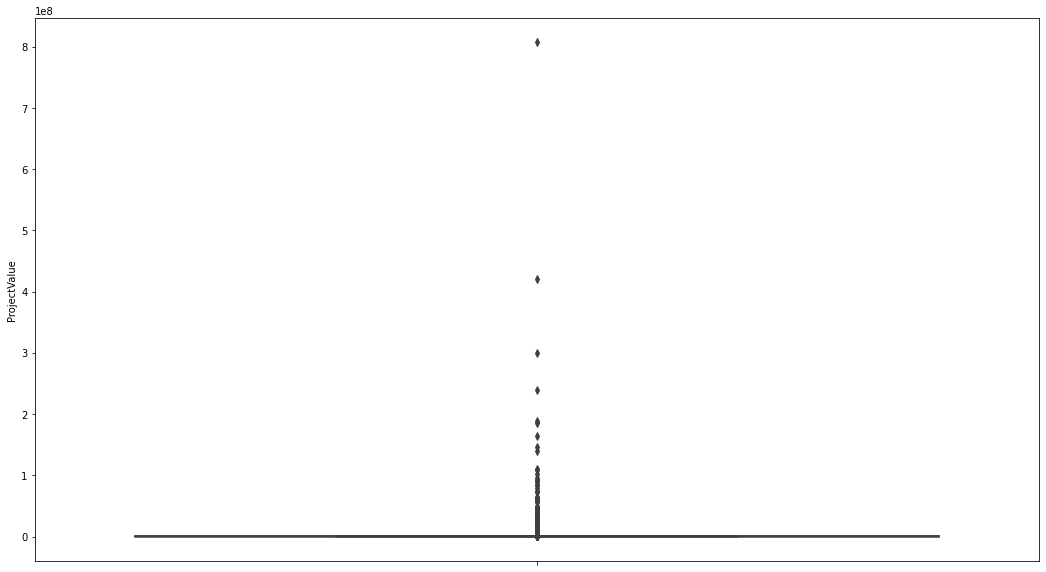

In [44]:
check_distribution(permits_df,'ProjectValue')

## Removing Outliers Using IQR Method

There are still a very large number of outliers within the data set. Because of this I will remove values using the IQR method.

In [45]:
Q1 = permits_df.ProjectValue.quantile(0.25)
Q3 = permits_df.ProjectValue.quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

permits_df = permits_df[(permits_df.ProjectValue > lower_limit)&(permits_df.ProjectValue < upper_limit)]

Null hypothesis of normality is rejected.


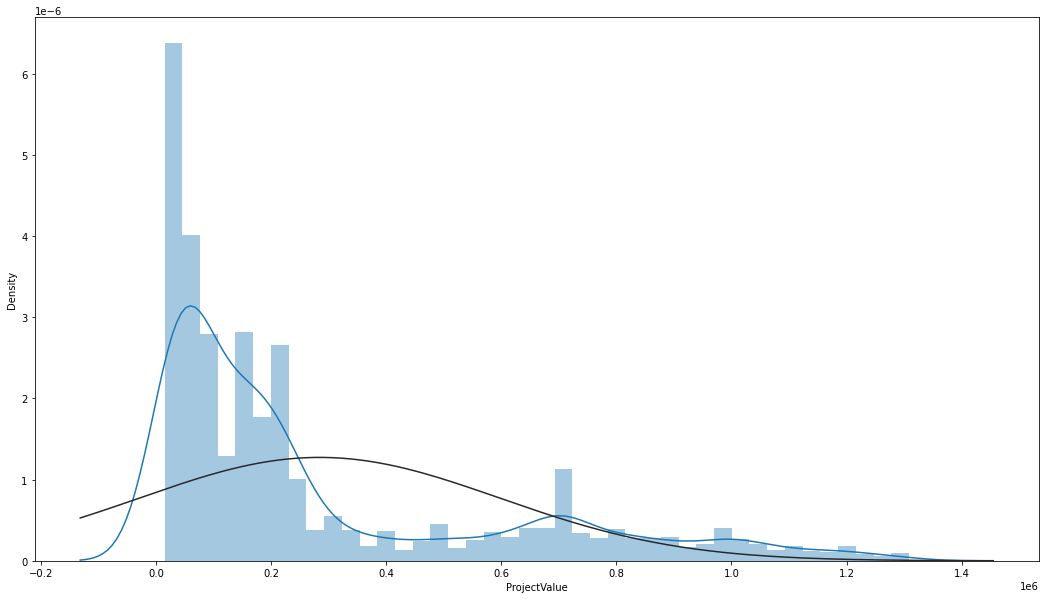

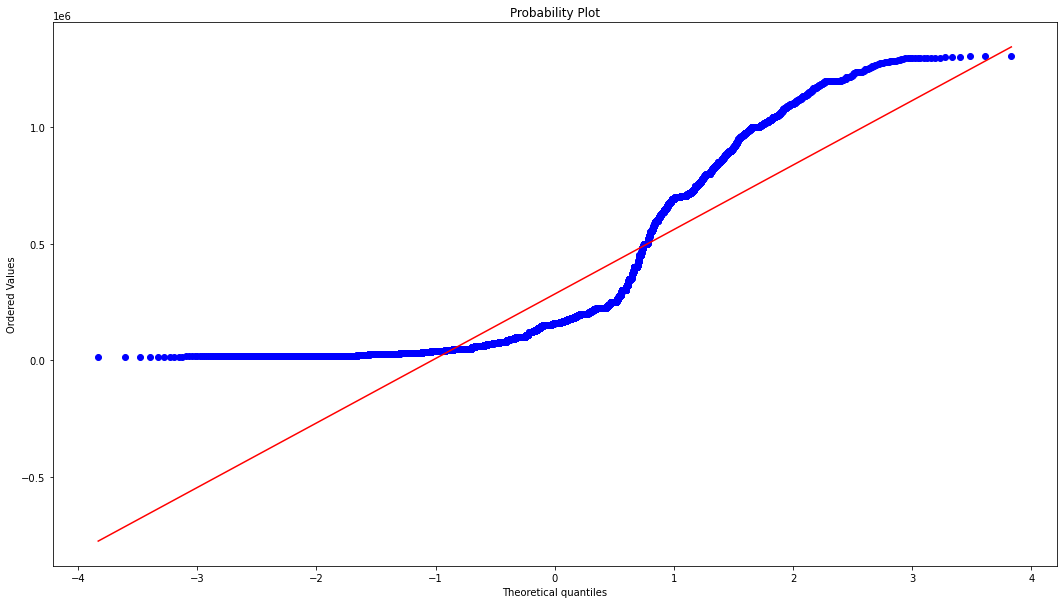

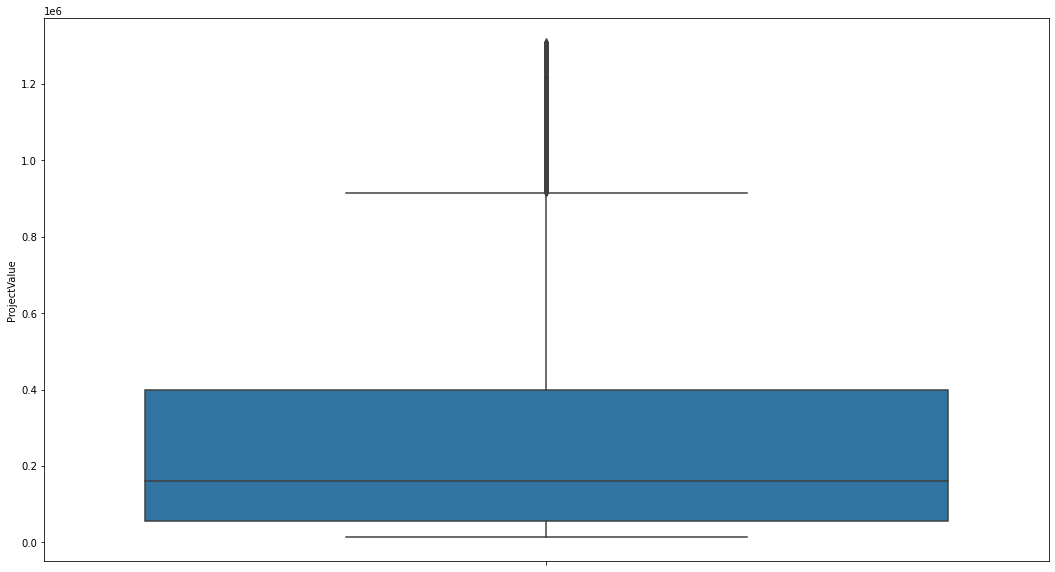

In [46]:
check_distribution(permits_df,'ProjectValue')

In [47]:
#Check how many categorical values remain after outlier removal

analyze_cat_cols()

------
Addition        6764
New Building    3774
Demolition       315
Name: WorkType, dtype: int64
------
Downtown                    2242
Kensington-Cedar Cottage     720
West End                     664
Fairview                     653
Sunset                       599
Renfrew-Collingwood          593
Hastings-Sunrise             589
Kitsilano                    578
Victoria-Fraserview          487
Riley Park                   443
Mount Pleasant               426
Dunbar-Southlands            398
Killarney                    335
Grandview-Woodland           326
Marpole                      303
West Point Grey              277
Arbutus-Ridge                254
Strathcona                   231
Kerrisdale                   224
Oakridge                     224
Shaughnessy                  151
South Cambie                 136
Name: Area, dtype: int64
------
Dwelling Uses                 6821
Office Uses                   2082
Retail Uses                    707
Service Uses                   

Project value is still not normally distributed and should be transformed. At this time I will assess the other numerical feature in the data set which is distance to nearest transit station.

In [48]:
skew_features = permits_df[['ProjectValue','DistanceToNearestTransitStation']].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features

DistanceToNearestTransitStation    1.394704
ProjectValue                       1.379051
dtype: float64

In [49]:
#Log transform the numerical features given they are highly skewed

cols_to_log = ['ProjectValue','DistanceToNearestTransitStation']

for i in cols_to_log:
    
    permits_df[i] = np.log(permits_df[i])

Null hypothesis of normality is rejected.


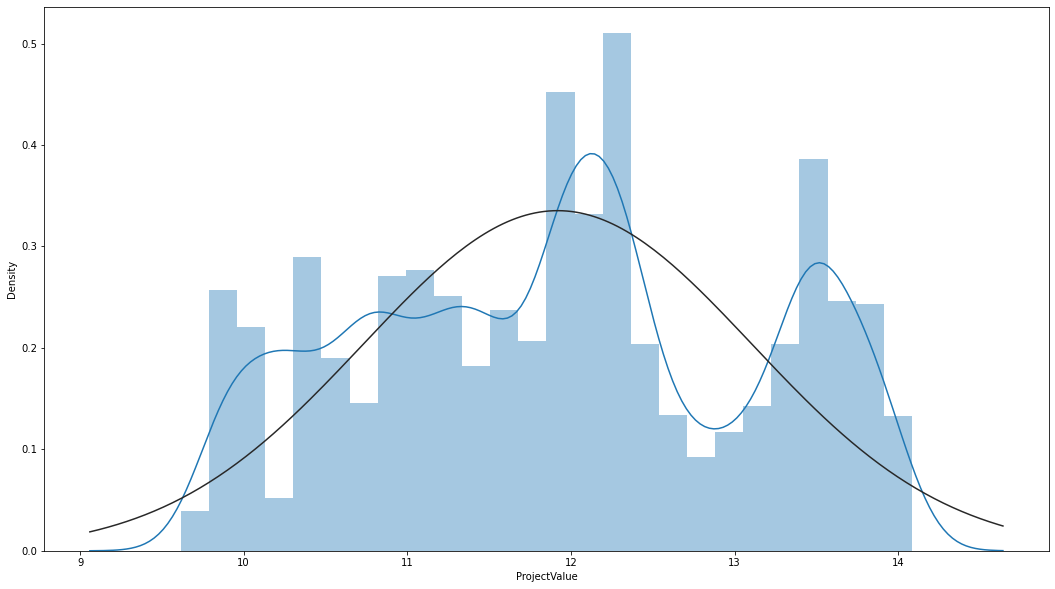

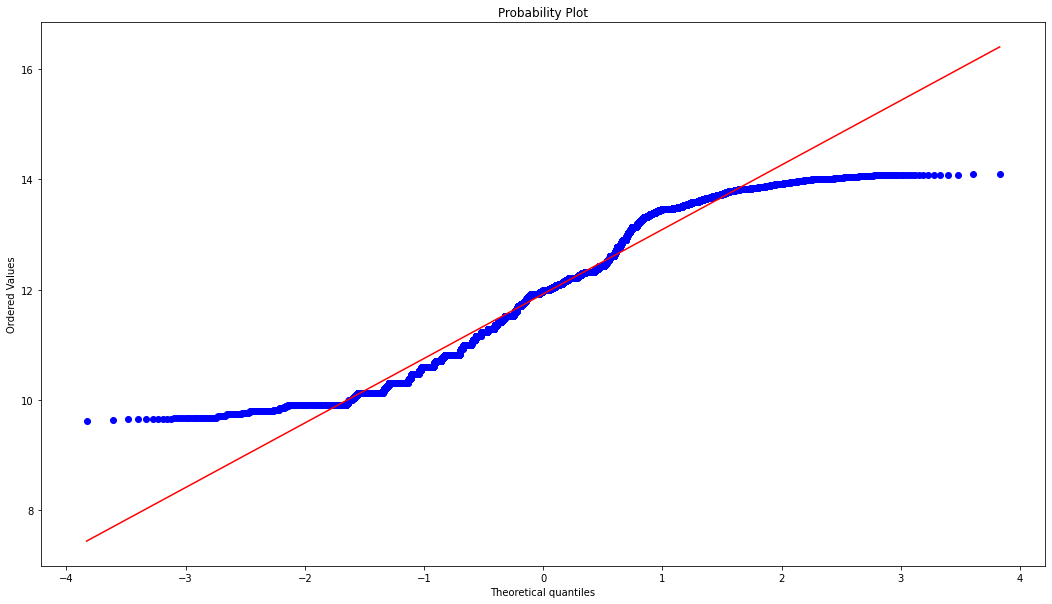

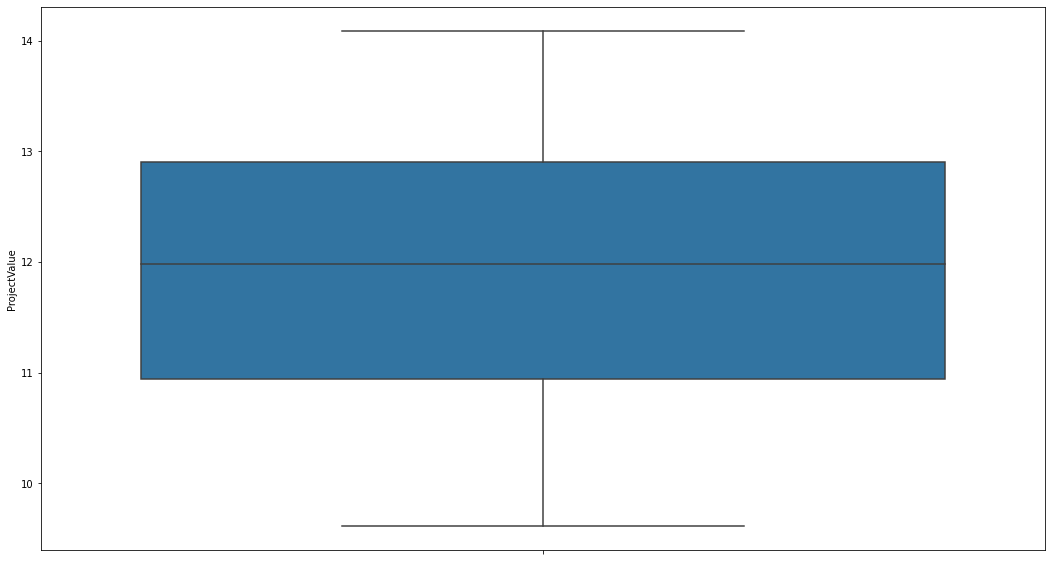

In [50]:
check_distribution(permits_df,'ProjectValue')

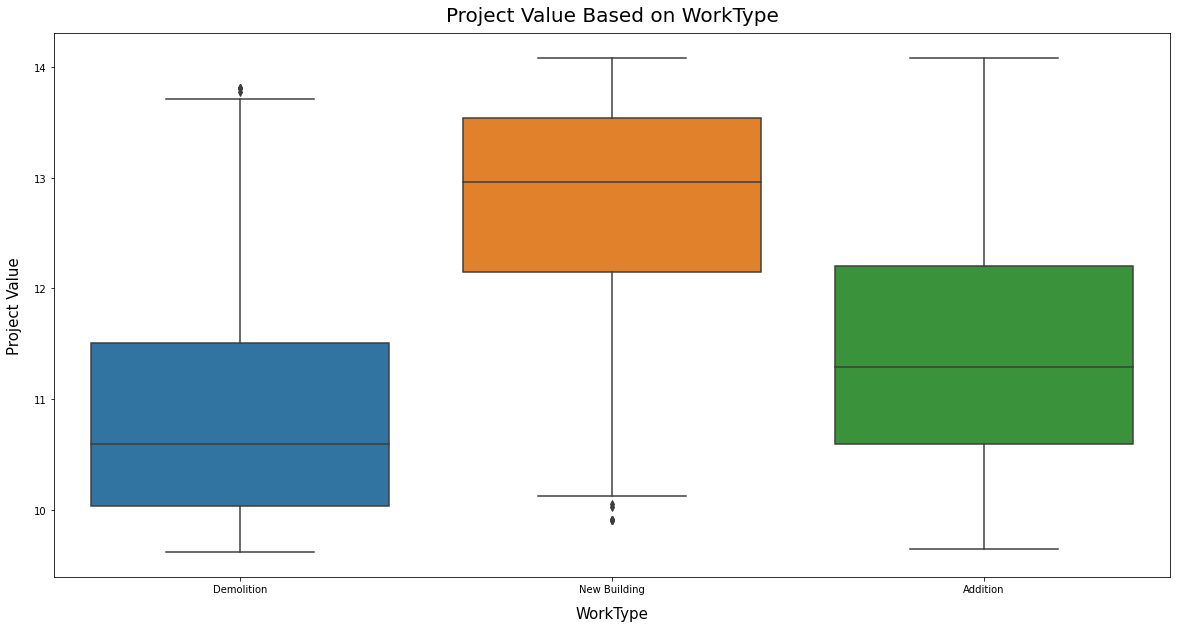

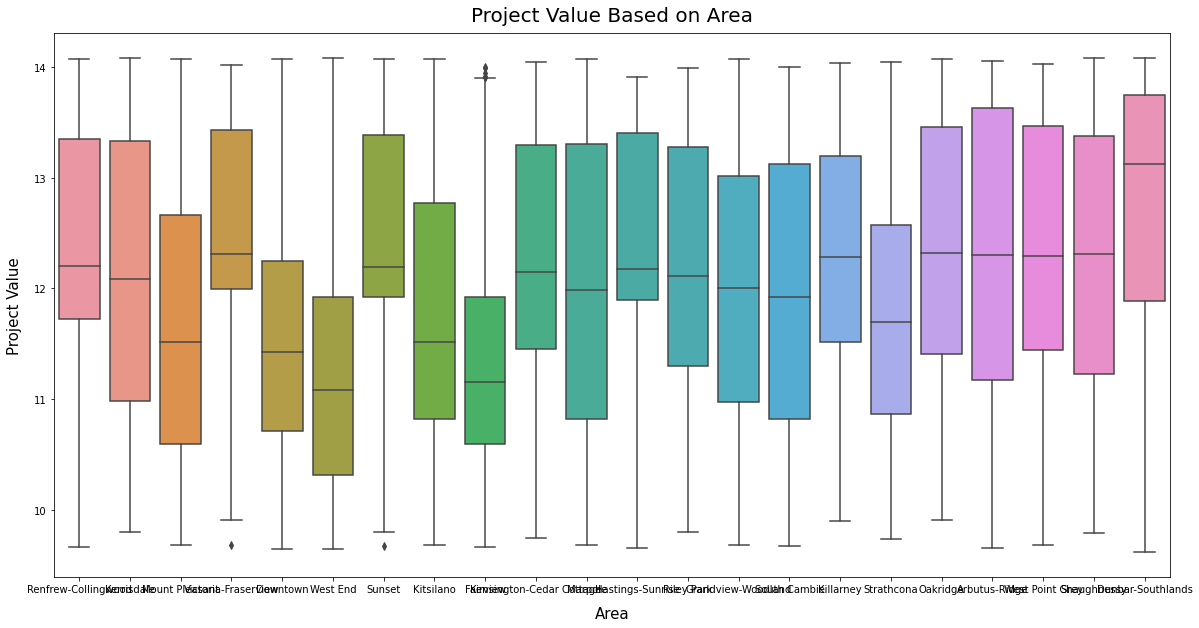

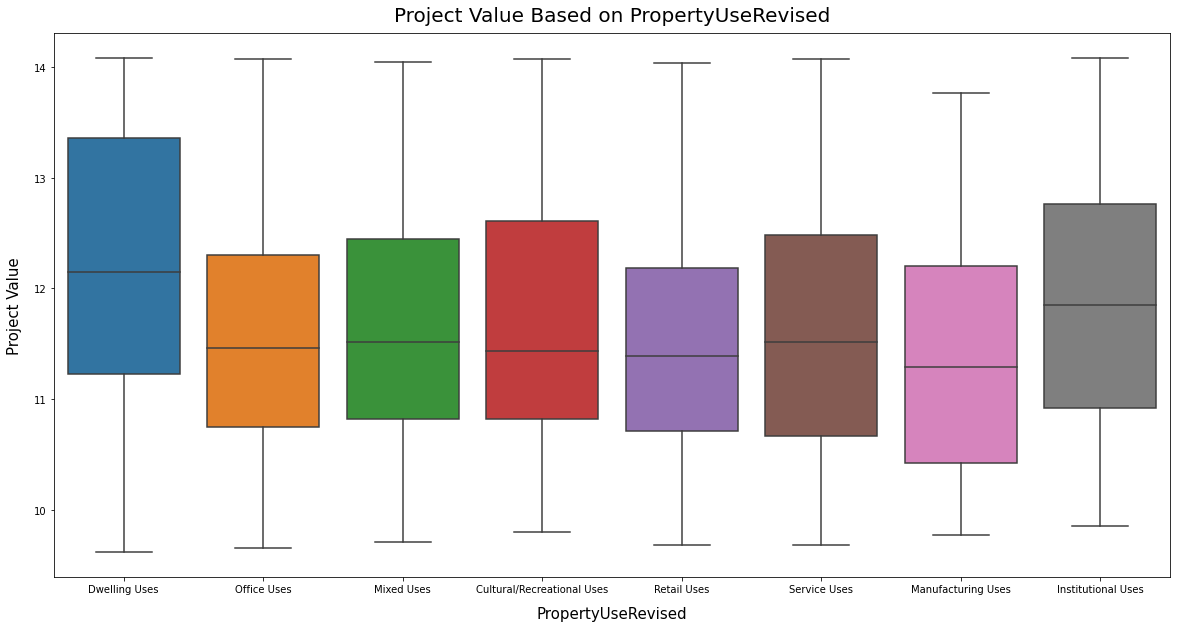

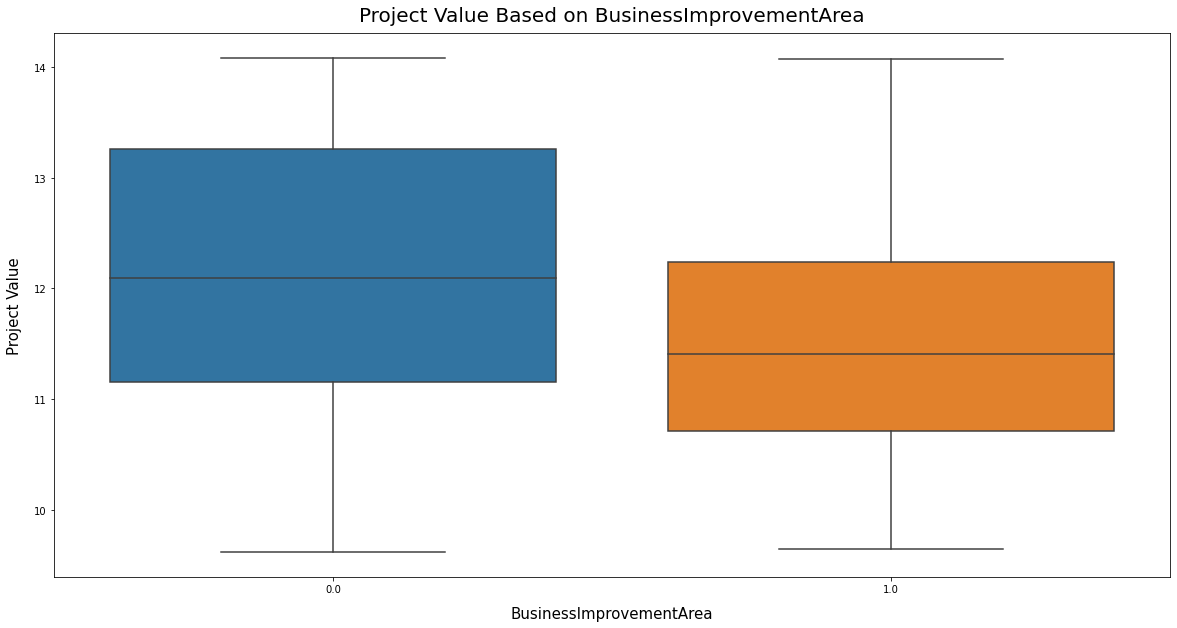

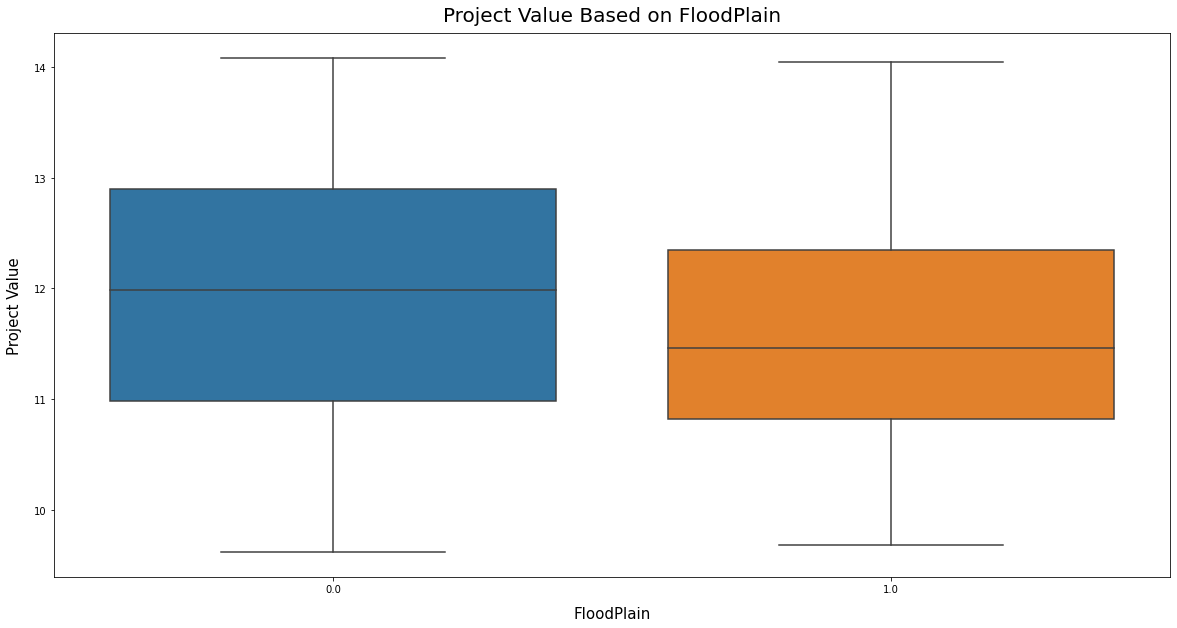

In [51]:
#Box plot for categorical features

cat_cols = ['WorkType','Area','PropertyUseRevised','BusinessImprovementArea','FloodPlain']

for col in cat_cols:
    plt.figure(figsize=(20,10))
    sns.boxplot(x= col, y= 'ProjectValue', data=permits_df)
    plt.xlabel(f"{col}", fontsize= 15, labelpad =12)
    plt.ylabel("Project Value", fontsize= 15, labelpad =12)
    plt.title(f"Project Value Based on {col}", fontsize=20, pad= 12);

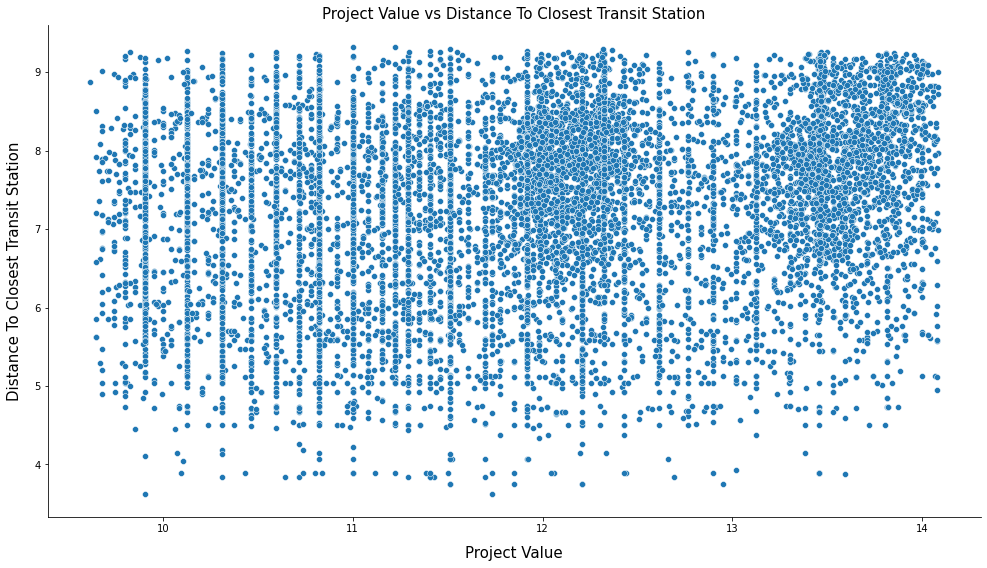

In [52]:
g = sns.relplot(x='ProjectValue', y='DistanceToNearestTransitStation', data=permits_df)
g.fig.set_size_inches(15,8)
plt.ylabel('Distance To Closest Transit Station', fontsize= 15, labelpad = 12)
plt.xlabel('Project Value', fontsize= 15, labelpad = 12)
plt.title('Project Value vs Distance To Closest Transit Station', fontsize= 15);

## Statistical Tests

Exploring Work Type

In [53]:
permits_df.groupby('WorkType')['ProjectValue'].describe()

,count,mean,std,min,25%,50%,75%,max
WorkType,,,,,,,,
Addition,6764.0,11.448784,1.059614,9.646011,10.596635,11.289782,12.206073,14.081560
Demolition,315.0,10.856205,1.005015,9.615872,10.032260,10.596635,11.510921,13.815511
New Building,3774.0,12.849293,0.786441,9.903488,12.150844,12.961994,13.542489,14.084445


In [54]:
#Seperate project value based on work type

demo = permits_df['ProjectValue'][(permits_df['WorkType'] == 'Demolition')]
new_building = permits_df['ProjectValue'][(permits_df['WorkType'] == 'New Building')]
addition = permits_df['ProjectValue'][(permits_df['WorkType'] == 'Addition')]

In [55]:
#Shapiro test assumption of normality

shapiro_demo = stats.shapiro(demo)
shapiro_new_building = stats.shapiro(new_building)
shapiro_addition = stats.shapiro(addition)

print(f"The p-value for demolition is {shapiro_demo.pvalue}")
print(f"The p-value for new buildings is {shapiro_new_building.pvalue}")
print(f"The p-value for additions is {shapiro_addition.pvalue}")


The p-value for demolition is 7.640000862041505e-15
The p-value for new buildings is 0.0
The p-value for additions is 1.6178577073907487e-37


All of the values failed the Shapiro test. Therefore a one-way ANOVA Test can not be used to asses the differences between these groups. Rather, a Kruskal-Wallice test will be used to asses whether the median values between these groups are the same. 

In [56]:
#Kruskal-Wallice Test

stats.kruskal(demo,new_building,addition)

KruskalResult(statistic=3684.129163071573, pvalue=0.0)

In [57]:
#Post hoc test

import scikit_posthocs as sp

work_type_post_hoc_data = [demo,new_building,addition]
sp.posthoc_dunn(work_type_post_hoc_data, p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,3.343130e-179,9.559455e-17
2,3.343130e-179,1.000000e+00,0.000000e+00
3,9.559455e-17,0.000000e+00,1.000000e+00


Based on the outcome of the Kruskal-Wallis test, and the post hoc test, it is highly unlikely that each of the working types have the same median value.

Exploring Area

In [58]:
permits_df.groupby('Area')['ProjectValue'].describe()

,count,mean,std,min,25%,50%,75%,max
Area,,,,,,,,
Arbutus-Ridge,254.0,12.214259,1.325912,9.648595,11.173499,12.305851,13.628326,14.057397
Downtown,2242.0,11.543044,1.077565,9.646981,10.714418,11.426683,12.243970,14.077875
Dunbar-Southlands,398.0,12.612006,1.272023,9.615872,11.883195,13.122363,13.747590,14.083704
Fairview,653.0,11.353148,1.008065,9.661416,10.596635,11.156251,11.918391,13.997832
Grandview-Woodland,326.0,11.971363,1.210467,9.680344,10.976674,12.000747,13.017003,14.077875
Hastings-Sunrise,589.0,12.322497,1.015195,9.648595,11.891362,12.176901,13.406037,13.909456
Kensington-Cedar Cottage,720.0,12.167398,1.133899,9.740969,11.455029,12.144194,13.297700,14.047451
Kerrisdale,224.0,12.059087,1.297967,9.798127,10.980347,12.086091,13.331992,14.084445
Killarney,335.0,12.205507,1.120425,9.898475,11.512925,12.284190,13.198017,14.038654


In [59]:
areas = permits_df['Area'].unique()
d = {area: pd.DataFrame() for area in areas}
for key in d.keys():
    d[key] = permits_df['ProjectValue'][permits_df.Area == key]
    
for k, v in d.items():
    print(f"The p-value for {k} is {stats.shapiro(v).pvalue}")

The p-value for Renfrew-Collingwood is 1.616447691573774e-14
The p-value for Kerrisdale is 4.888756066634414e-08
The p-value for Mount Pleasant is 6.649961831195483e-11
The p-value for Victoria-Fraserview is 3.928134774649605e-15
The p-value for Downtown is 5.587998837159588e-21
The p-value for West End is 1.776809102054525e-16
The p-value for Sunset is 1.5996841895696062e-15
The p-value for Kitsilano is 5.705180793937059e-13
The p-value for Fairview is 7.328145252075147e-13
The p-value for Kensington-Cedar Cottage is 3.932410014632193e-16
The p-value for Marpole is 4.778757944912115e-10
The p-value for Hastings-Sunrise is 2.4572446975670934e-16
The p-value for Riley Park is 3.320204527978987e-11
The p-value for Grandview-Woodland is 2.1180373011020492e-08
The p-value for South Cambie is 4.381894177640788e-05
The p-value for Killarney is 3.540410742353117e-10
The p-value for Strathcona is 0.0006103514460846782
The p-value for Oakridge is 2.362244089226806e-07
The p-value for Arbutus-Ri

All of the areas have failed the assumption of normality. Therefore the Kruskal-Wallice test will be applied again.

In [60]:
stats.kruskal(*d.values())

KruskalResult(statistic=1185.3987307681175, pvalue=7.73628216979263e-238)

Based on the outcome of the Kruskal-Wallis test, it is highly unlikely that each of Vancouver's areas have the same median value in project costs.

Exploring Property Use

In [61]:
permits_df.groupby('PropertyUseRevised')['ProjectValue'].describe()

,count,mean,std,min,25%,50%,75%,max
PropertyUseRevised,,,,,,,,
Cultural/Recreational Uses,124.0,11.665760,1.095480,9.798127,10.819778,11.434599,12.611538,14.077875
Dwelling Uses,6821.0,12.124844,1.205247,9.615872,11.225243,12.152408,13.360191,14.084445
Institutional Uses,257.0,11.865576,1.103859,9.852194,10.915088,11.849398,12.765688,14.081560
Manufacturing Uses,100.0,11.386179,1.062384,9.769956,10.424566,11.289782,12.206697,13.764743
Mixed Uses,261.0,11.621869,1.114516,9.711116,10.819778,11.512925,12.445090,14.046622
Office Uses,2082.0,11.563963,1.084505,9.648595,10.745593,11.461632,12.301383,14.077875
Retail Uses,707.0,11.460013,0.966529,9.680344,10.714418,11.388495,12.188259,14.038654
Service Uses,501.0,11.582073,1.127848,9.680344,10.668955,11.512925,12.482249,14.077875


In [62]:
#Test for normality on property use

prop_use = permits_df['PropertyUseRevised'].unique()
p = {use: pd.DataFrame() for use in prop_use}
for key in p.keys():
    p[key] = permits_df['ProjectValue'][permits_df.PropertyUseRevised == key]
    
for k, v in p.items():
    print(f"The p-value for {k} is {stats.shapiro(v).pvalue}")

The p-value for Dwelling Uses is 1.723597111119525e-43
The p-value for Office Uses is 4.6419621448848506e-20
The p-value for Mixed Uses is 1.8996821381733753e-05
The p-value for Cultural/Recreational Uses is 0.0006610219716094434
The p-value for Retail Uses is 1.3330584636150888e-08
The p-value for Service Uses is 4.480100179726776e-10
The p-value for Manufacturing Uses is 0.0021669918205589056
The p-value for Institutional Uses is 1.0822336662386078e-05


In [63]:
stats.kruskal(*p.values())

KruskalResult(statistic=587.458938068061, pvalue=1.2215310388110197e-122)

Based on the outcome of the Kruskal-Wallis test, it is highly unlikely that property uses have the same median value in project costs.

Exploring Business Improvement Areas

In [64]:
permits_df.groupby('BusinessImprovementArea')['ProjectValue'].describe()

,count,mean,std,min,25%,50%,75%,max
BusinessImprovementArea,,,,,,,,
0.0,7910.0,12.063931,1.198725,9.615872,11.156251,12.096676,13.263863,14.084445
1.0,2943.0,11.527971,1.071971,9.646981,10.714418,11.407565,12.242887,14.077875


In [65]:
bia = permits_df['BusinessImprovementArea'].unique()
p = {use: pd.DataFrame() for use in bia}
for key in p.keys():
    p[key] = permits_df['ProjectValue'][permits_df.BusinessImprovementArea == key]
    
for k, v in p.items():
    print(f"The p-value for {k} is {stats.shapiro(v).pvalue}")

The p-value for 0.0 is 6.165713243029195e-44
The p-value for 1.0 is 3.028605436946729e-24


Since neither of the options for Business Improvement Areas are normally distributed, a t-test cannot be used to assess the means of the groups. Therefore a Wilcoxon rank-sum test will be applied to assess whether the values in one sample are more likely to be larger than the values in the other sample.

In [66]:
stats.ranksums(*p.values())

RanksumsResult(statistic=21.088858344407843, pvalue=1.0066155481822714e-98)

Based on the results of the Wilcoxon rank-sum test, it is highly unlikely that the two sets of permits are from the same distribution. This suggests that the values of permits outside of business improvement areas are in fact larger than those permits that are within business improvement areas.

Exploring Flood Plain

In [67]:
permits_df.groupby('FloodPlain')['ProjectValue'].describe()

,count,mean,std,min,25%,50%,75%,max
FloodPlain,,,,,,,,
0.0,10579.0,11.926537,1.190669,9.615872,10.985293,11.982929,12.899220,14.084445
1.0,274.0,11.611960,1.114076,9.680344,10.819778,11.461632,12.343322,14.049956


In [68]:
fp = permits_df['FloodPlain'].unique()
p = {use: pd.DataFrame() for use in fp}
for key in p.keys():
    p[key] = permits_df['ProjectValue'][permits_df.BusinessImprovementArea == key]
    
for k, v in p.items():
    print(f"The p-value for {k} is {stats.shapiro(v).pvalue}")

The p-value for 0.0 is 6.165713243029195e-44
The p-value for 1.0 is 3.028605436946729e-24


Since neither of the options for flood plains are normally distributed, a t-test cannot be used to assess the means of the groups. Therefore a Wilcoxon rank-sum test will be applied to assess whether the values in one sample are more likely to be larger than the values in the other sample.

In [69]:
stats.ranksums(*p.values())

RanksumsResult(statistic=21.088858344407843, pvalue=1.0066155481822714e-98)

Based on the results of the Wilcoxon rank-sum test, it is highly unlikely that the two sets of permits are from the same distribution. This suggests that the values of permits outside of flood plains is in fact larger than those permits that are outside of flood plains.

Exploring Distance to Closest Transit Station

In [70]:
pearson_test = stats.pearsonr(permits_df.ProjectValue, permits_df.DistanceToNearestTransitStation)
print(f"The correlation between a permits project value and distance to the nearest transit station is {pearson_test[0]}. The significance of the relationship is {pearson_test[1]}.")

The correlation between a permits project value and distance to the nearest transit station is 0.1771041108789006. The significance of the relationship is 3.50402429361868e-77.


Given that the proximity to transit station has a statistically significant impact on a projects value, it will be removed from the analysis.

## Creating the Final Dataframe for Machine Learning

In [71]:
permits_df.head()

,geometry,ProjectValue,WorkType,Area,PropertyUseRevised,BusinessImprovementArea,FloodPlain,DistanceToNearestTransitStation
20,POINT (-13698550.139 6318884.625),9.903488,Demolition,Renfrew-Collingwood,Dwelling Uses,0.0,0.0,7.097735
46,POINT (-13696158.885 6318105.221),11.811176,New Building,Renfrew-Collingwood,Dwelling Uses,0.0,0.0,7.037010
48,POINT (-13707985.868 6314680.669),11.274262,Addition,Kerrisdale,Office Uses,0.0,0.0,7.927742
49,POINT (-13704001.198 6319645.303),10.819778,Addition,Mount Pleasant,Office Uses,1.0,0.0,6.981501
50,POINT (-13698128.561 6313095.235),10.691945,Addition,Victoria-Fraserview,Office Uses,0.0,0.0,8.088189


In [72]:
#Drop geometry and distance to transit station

final_cols_to_drop = ['geometry','DistanceToNearestTransitStation']

permits_df.drop(columns = final_cols_to_drop, inplace = True)

In [73]:
permits_df.head()

,ProjectValue,WorkType,Area,PropertyUseRevised,BusinessImprovementArea,FloodPlain
20,9.903488,Demolition,Renfrew-Collingwood,Dwelling Uses,0.0,0.0
46,11.811176,New Building,Renfrew-Collingwood,Dwelling Uses,0.0,0.0
48,11.274262,Addition,Kerrisdale,Office Uses,0.0,0.0
49,10.819778,Addition,Mount Pleasant,Office Uses,1.0,0.0
50,10.691945,Addition,Victoria-Fraserview,Office Uses,0.0,0.0


In [74]:
# One hot encode work type, area, and property use

final_cat_col = ['WorkType','Area','PropertyUseRevised']

model = pd.get_dummies(permits_df,columns=final_cat_col, drop_first = True)

In [75]:
model.head()

,ProjectValue,BusinessImprovementArea,FloodPlain,WorkType_Demolition,WorkType_New Building,Area_Downtown,Area_Dunbar-Southlands,Area_Fairview,Area_Grandview-Woodland,Area_Hastings-Sunrise,...,Area_Victoria-Fraserview,Area_West End,Area_West Point Grey,PropertyUseRevised_Dwelling Uses,PropertyUseRevised_Institutional Uses,PropertyUseRevised_Manufacturing Uses,PropertyUseRevised_Mixed Uses,PropertyUseRevised_Office Uses,PropertyUseRevised_Retail Uses,PropertyUseRevised_Service Uses
20,9.903488,0.0,0.0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
46,11.811176,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
48,11.274262,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
49,10.819778,1.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
50,10.691945,0.0,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [76]:
#Establish X and y

y = model.ProjectValue
X = model.drop(['ProjectValue'], axis =1)

In [102]:
#Import various models and performance metrics

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [107]:
#Function for evaluating model performance

def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r_2 = r2_score(true, predicted)
    print('Mean Absolute Error:', np.round(mae))
    print('Root Mean Squared Error:', np.round(rmse))
    print('R2 Score:', r_2)
    print('__________________________________')

# Establish A Baseline Model With Linear Regression

In [79]:
#Establish the hold out set to test cross val after fitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [108]:
#Create instance of linear regression model
regr = LinearRegression()

#Fit model
regr.fit(X_train, y_train)

#Convert the log values back to original scale using np.exp
preds = np.exp(regr.predict(X_test))

print_evaluate(np.exp(y_test), preds)


Mean Absolute Error: 180586.0
Root Mean Sqaured Error: 271116.0
R2 Score: 0.21436573096309008
__________________________________


In [81]:
#Create a pipeline for each model that is going to be tested.

pipelines = {
    'RandomForest': make_pipeline(RandomForestRegressor(random_state=1)),    
    'GradientBoost': make_pipeline(GradientBoostingRegressor(random_state=1))
}

In [82]:
#Establish all the hyperparameters in a dictionary that are going to be tested on the training sets

hyperparameters = {

'RandomForest' : {
     'randomforestregressor__n_estimators' : [50, 100, 150, 200],
     'randomforestregressor__min_samples_leaf' : [1, 3, 5],
     'randomforestregressor__max_depth' : [3, 5, 10, 15],    
    },

'GradientBoost' : {
    'gradientboostingregressor__n_estimators' : [50, 100, 150, 200],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.15, 0.3],
    'gradientboostingregressor__max_depth' : [3, 6, 10, 15]
    }
    
}

In [83]:

fitted_models = {} #Establishes a dictionary that will hold the model and its best performing hyperparameters

# Grid search each model and hyperparameter with 5 fold cross validation

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, 
                         hyperparameters[name], 
                         cv=5,
                         return_train_score = False)
    model.fit(X_train, y_train)
    fitted_models[name] = model

In [109]:
# Calculate MAE, and RMSE by passing X_test and y_test to each model. Print out the best performing parameters using the best_params_ command
# Using the np.exp will convert the log values back to their original scale

for name, model in fitted_models.items():
   pred = model.predict(X_test)
   print(name)
   print(' — — — — ')
   print('Mean Absolute Error:', mean_absolute_error(np.exp(y_test), np.exp(pred)))
   print('Root Mean Squared Error:', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred))))
   print('R2 Score:', r2_score(np.exp(y_test), np.exp(pred)))   
   print() 
   print('This models best performing parameters are ' + str(model.best_params_))
   print()

RandomForest
 — — — — 
Mean Absolute Error: 178964.10225608616
Root Mean Squared Error: 269962.6387823226
R2 Score: 0.22103632354829683

This models best performing parameters are {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__n_estimators': 150}

GradientBoost
 — — — — 
Mean Absolute Error: 179496.75442055546
Root Mean Squared Error: 270933.312537235
R2 Score: 0.21542459189153795

This models best performing parameters are {'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 200}

